In [13]:
import scipy.linalg
import scipy as sp
import itertools

* $d$: Dimension of the signal
* $m$: Number of measurments 
* $A$: Measurement matrix $m\times d$
* $X$: Restricted $d$-dimensional signal space s.t. $Ax\neq 0$ for all $x\in X$. We can restrict by requiring $x\in X$ to be $s$-sparse, or further, to live not over $\mathbb{R}$ but over $\mathbb{Q}$. While the columns of $A$ might be linearly dependent over $\mathbb{R}$, they might still be linearly independent over $\mathbb{Q}$.
* $s$: Number of non-zero entries in the signal $x\in X$
* $k$: $|A|$, i.e. $\max(|a_{i,j}|)$

# Example 1

In [48]:
# Compute the Pl\:{u}cker coordinates of A
def compute_plucker_coordinates(A):
    m,d = A.shape
    multisets = itertools.combinations(range(d),m)
    return [sp.linalg.det(A[:, multiset]) for multiset in multisets]

In [161]:
# s in {1,2,3}
k = 1
m = 3
d = 6
A = sp.array([
    [1,1,1,1,1,1],
    [1,1,0,0,-1,-1],
    [1,0,1,-1,0,-1]])

# This 3x12 A has 31 zero plucker coordinates
# What can we say if we don't require a unique solution, 
# but just a solution up to some kind of equivalence? 
# How would that allow us to relax the requirements on A in a useful way? 
# A = sp.array([
#     [1,0,0,-1,0,-1,1,-1,0,1,-1,1], 
#     [0,1,0,-1,-1,0,-1,0,1,1,1,-1], 
#     [0,0,1,0,-1,-1,0,1,-1,-1,1,1]])

In [162]:
# Check for zero Pl\:{u}cker coordinates
len([coord for coord in compute_plucker_coordinates(A) if not coord])

0

In [140]:
sp.dot(A, A.T)

array([[6, 0, 0],
       [0, 4, 2],
       [0, 2, 4]])

Singular values of $A$ are the square roots of the eigenvalues. Here, the characteristic polynomial is $(6-x)(x^2-8x+12)$, which has roots $\{6,6,2\}$. The smallest singular value is thus $\sqrt{2}$

In [167]:
sp.linalg.svdvals(A)

array([2.44948974, 2.44948974, 1.41421356])

In [89]:
sp.sqrt(2)

1.4142135623730951

In [168]:
sp.roots([1,0,0,-1])

array([-0.5+0.8660254j, -0.5-0.8660254j,  1. +0.j       ])

# Example 2

* $\theta = 2^{1/3}$
* $\xi = e^{\frac{2\pi i}{3}}$

$$A=
\begin{pmatrix} 
1+\theta+\theta^2& 1+ \theta & 1+\theta^2 & 1-\theta^2 & 1 - \theta & 1-\theta - \theta^2 \\ 
1+\xi\theta+\xi^2\theta^2 & 1+ \xi\theta & 1+\xi^2\theta^2 & 1-\xi^2\theta^2 & 1 - \xi\theta & 1-\xi\theta - \xi^2\theta^2  \\ 
1+\xi^2\theta+\xi\theta^2 & 1+ \xi^2\theta & 1+\xi\theta^2 & 1-\xi\theta^2 & 1 - \xi^2\theta & 1-\xi^2\theta - \xi\theta^2  
\end{pmatrix}$$

In [191]:
theta = 2**(1./3)
xi = sp.e**((2*sp.pi*1j)/3)

In [315]:
A = sp.array([
    [1+theta+theta**2, 1+theta, 1+theta**2 , 1-theta**2, 1-theta, 1-theta-theta**2],
    [1+xi*theta+xi**2*theta**2, 1+xi*theta, 1+xi**2*theta**2 , 1-xi**2*theta**2, 1-xi*theta, 1-xi*theta-xi**2*theta**2],
    [1+xi**2*theta+xi*theta**2, 1+xi**2*theta, 1+xi*theta**2 , 1-xi*theta**2, 1-xi**2*theta, 1-xi**2*theta-xi*theta**2]
])

In [316]:
sp.linalg.svdvals(A)

array([6.15496158, 4.24264069, 3.37688699])

In [317]:
# Check for zero Pl\:{u}cker coordinates
len([coord for coord in compute_plucker_coordinates(A) if not coord])

0

# Reconstruction

Reconstruction results for the matrix described in Example 2 using 
* L1-minimization (L1), 
* Orthogonal Matching Pursuit (OMP), 
* Hard Thresholding (HT),
* least-squares (LS).

Signals are generated with random support, and entries follow a Gaussian distribution with mean 0 and variance $\sigma^2= 25$ and were then rounded to the nearest integer. 

In [331]:
import cvxpy as cp
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [319]:
def get_x(d, s):
    x = sp.zeros(d)
    idxs = sp.random.choice(d, s, replace=False)
    x[idxs] = sp.rint(sp.random.normal(0,5,s))
    return x

In [320]:
x = get_x(6,1)
y = sp.dot(A,x)

In [335]:
def loss_fn(X, Y, beta):
    return cp.norm(cp.matmul(X, beta) - Y,2)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

In [336]:
beta = cp.Variable(6)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(A, y, beta, lambd)))

lambd_values = sp.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(A, y, beta))
    test_errors.append(mse(A, y, beta))
    beta_values.append(beta.value)

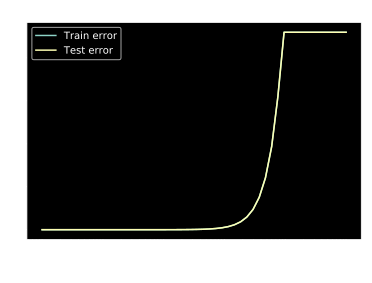

In [337]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)